# Requirements

In [32]:
#!pip install wikipedia-api
!pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 325.1 kB/s eta 0:02:55
   ---------------------------------------- 0.0/56.8 MB 326.8 kB/s eta 0:02:54
   ---------------------------------------- 0.1/56.8 MB 525.1 kB/s eta 0:01:49
   ---------------------------------------- 0.3/56.8 MB 1.2 MB/s eta 0:00:47
   ---------------------------------------- 0.6/56.8 MB 2.5 MB/s eta 0:00:23
    --------------------------------------- 1.2/56.8 MB 3.9 MB/s eta 0:00:15
   - -------------------------------------- 1.6/56.8 MB 4.7 MB/s eta 0:00:12
   - -------------------------------------- 2.1/56.8 MB 5.6 MB/s eta 0:00:10
   - -------------------------------------- 2.7/56.8 MB 6.4 MB/s eta 0:00:09
   -- ------------------------------------- 3.4/56.8 MB 7.3 MB/s eta 0:00:08
   -- --------

# Import Dataset

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("videos.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92759 entries, 0 to 92758
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   kind                  92759 non-null  object 
 1   videoId               92759 non-null  int64  
 2   publishedAt           92759 non-null  object 
 3   channelId             92759 non-null  int64  
 4   title                 92759 non-null  object 
 5   description           35237 non-null  object 
 6   tags                  20891 non-null  object 
 7   defaultLanguage       15785 non-null  object 
 8   defaultAudioLanguage  29956 non-null  object 
 9   contentDuration       91492 non-null  object 
 10  viewCount             91490 non-null  float64
 11  likeCount             86630 non-null  float64
 12  favouriteCount        91492 non-null  float64
 13  commentCount          90294 non-null  float64
 14  topicCategories       91228 non-null  object 
dtypes: float64(4), int6

In [4]:
df.head()

,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories
0,youtube#video,85806,2024-01-15 00:59:29+00:00,33807,Unlocking the Benefits of Face Masks for Skin ...,NaN,NaN,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http..."
1,youtube#video,30556,2023-10-27 19:32:16+00:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,NaN,NaN,NaN,NaN,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
2,youtube#video,51771,2024-09-28 01:23:22+00:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,NaN,NaN,NaN,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
3,youtube#video,45298,2023-07-13 15:19:28+00:00,50139,#shortvedio #balayage,NaN,NaN,NaN,NaN,PT14S,1207.0,20.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
4,youtube#video,43611,2023-04-29 18:47:37+00:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,NaN,NaN,NaN,en,PT56S,8647.0,268.0,0.0,7.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...


# Formatting and Cleaning

In [5]:
print(df['kind'].unique())

df.drop('kind', axis=1, inplace=True)

['youtube#video']


In [6]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

In [7]:
from datetime import timedelta
import re

# Function to convert ISO 8601 duration string to total seconds
def convert_duration_to_seconds(duration_str):
    if not isinstance(duration_str, str):
        return None

    # Use regular expressions to find hours, minutes, and seconds
    hours = re.search(r'(\d+)H', duration_str)
    minutes = re.search(r'(\d+)M', duration_str)
    seconds = re.search(r'(\d+)S', duration_str)

    h = int(hours.group(1)) if hours else 0
    m = int(minutes.group(1)) if minutes else 0
    s = int(seconds.group(1)) if seconds else 0

    return timedelta(hours=h, minutes=m, seconds=s).total_seconds()

# Apply the conversion function to the 'contentDuration' column
df['contentDuration_seconds'] = df['contentDuration'].apply(convert_duration_to_seconds)

# Feature Generation

## 1. Topic Extraction and Wikipedia Enrichment

In [8]:
# Extract the topic out from the Wikipedia URLs
import ast

def extract_topic_from_wiki(url_list):
    if pd.isna(url_list):
        return []

    # If it's a string that looks like a list, safely parse it
    if isinstance(url_list, str):
        try:
            parsed = ast.literal_eval(url_list)
            if isinstance(parsed, list):
                url_list = parsed
            else:
                url_list = [url_list]
        except Exception:
            url_list = [url_list]

    topics = []
    for url in url_list:
        if not isinstance(url, str):
            continue
        topic = url.split("/")[-1]              # take last part
        topic = topic.replace("_", " ").strip() # underscores → spaces
        topic = topic.strip("']")               # remove trailing ' or ]
        topics.append(topic)

    return topics

df['topicCleaned'] = df['topicCategories'].apply(extract_topic_from_wiki)

In [9]:
#List all the unique topics/categories in this dataset
all_topics = set([t for sublist in df['topicCleaned'] for t in sublist if isinstance(sublist, list)])
print("Total unique topics:", len(all_topics))
print(sorted(all_topics))

Total unique topics: 45
['Action game', 'Action-adventure game', 'Basketball', 'Business', 'Casual game', 'Country music', 'Cricket', 'Electronic music', 'Entertainment', 'Fashion', 'Film', 'Food', 'Health', 'Hip hop music', 'Hobby', 'Humour', 'Jazz', 'Knowledge', 'Lifestyle (sociology)', 'Military', 'Mixed martial arts', 'Music', 'Music of Asia', 'Music of Latin America', 'Performing arts', 'Pet', 'Physical attractiveness', 'Physical fitness', 'Politics', 'Pop music', 'Puzzle video game', 'Religion', 'Rhythm and blues', 'Role-playing video game', 'Society', 'Soul music', 'Sport', 'Sports game', 'Strategy video game', 'Technology', 'Television program', 'Tennis', 'Tourism', 'Vehicle', 'Video game culture']


## 2. Like-View ratio, Comment-view Ratio

In [10]:
df['like_view_ratio'] = np.where(df['viewCount']>0, df['likeCount'] / df['viewCount'], np.nan)
df['comment_view_ratio'] = np.where(df['viewCount']>0, df['commentCount'] / df['viewCount'], np.nan)

## 3. Video duration segmentation

In [11]:
bins = [0, 30, 120, 300, 900, 3600, np.inf]
labels = ['<30s', '30-120s', '2-5m', '5-15m', '15-60m', '>60m']
try:
  df['length_bucket'] = pd.cut(df['contentDuration_seconds'].fillna(-1), bins=[-1,30,120,300,900,3600,10**9], labels=labels)
except Exception:
  df['length_bucket'] = 'unknown'

## 4. Tags Cleaning

In [12]:
def extract_hashtags(text):
  if pd.isna(text):
    return []
  return re.findall(r"#(\w+)", str(text))

hashtags_from_title = df['title'].apply(extract_hashtags) if 'title' in df.columns else [[] for _ in range(len(df))]
hashtags_from_desc = df['description'].apply(extract_hashtags) if 'description' in df.columns else [[] for _ in range(len(df))]

def ensure_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    return [x]

merged_tags = []
for base, ht1, ht2 in zip(df['tags'], hashtags_from_title, hashtags_from_desc):
  base = ensure_list(base)
  ht1 = ensure_list(ht1)
  ht2 = ensure_list(ht2)
  merged = list(set(base) | set(ht1) | set(ht2))
  merged_tags.append(merged)


df['tags'] = merged_tags

In [13]:
# Attempt to enrich dataset with more information from wikipedia
import wikipediaapi
import requests

import urllib.parse
from datetime import datetime

def get_wiki_pageviews(page_title, start="20230101", end=None):
    if end is None:
        # default to today's date in YYYYMMDD
        end = datetime.today().strftime("%Y%m%d")

    # Encode title properly for Wikimedia API
    encoded_title = urllib.parse.quote(page_title, safe="")

    url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{encoded_title}/daily/{start}/{end}"
    r = requests.get(url)

    if r.status_code == 200:
        data = r.json().get("items", [])
        if data:
            return sum(item["views"] for item in data)
    return 0  # return 0 instead of None if no data

wiki_wiki = wikipediaapi.Wikipedia(user_agent="LoReal (ryanchinjh@gmail.com)", language='en')



def enrich_wiki_topic(topic_url):
    try:
        topic = topic_url.split("/")[-1]
        page_title = topic  # keep underscores
        page = wiki_wiki.page(topic.replace("_", " "))
        summary = page.summary[0:500] if page.exists() else None
        pageviews = get_wiki_pageviews(page_title)
        return {
            "topic": topic.replace("_", " "),
            #"summary": summary,
            "categories": list(page.categories.keys()) if page.exists() else [],
            "pageviews": pageviews
        }
    except Exception:
        return {"topic": None, "summary": None, "categories": [], "pageviews": 0}

print(enrich_wiki_topic("https://en.wikipedia.org/wiki/Lifestyle_(sociology)"))

{'topic': 'Lifestyle (sociology)', 'categories': ['Category:1920s neologisms', 'Category:Articles containing German-language text', 'Category:Articles with short description', 'Category:Lifestyle', 'Category:Personal life', 'Category:Philosophy of life', 'Category:Short description matches Wikidata', 'Category:Sociological terminology', 'Category:Subcultures', 'Category:Webarchive template wayback links', 'Category:Wikipedia indefinitely semi-protected pages'], 'pageviews': 0}


**Note: Page views still don't work. Will look into it more later**

# Creating separate dataframe for channel stats

In [14]:
channel_df = df.groupby('channelId')['viewCount'].sum()

In [15]:
channel_agg = df.groupby('channelId').agg(
    total_view=('viewCount', 'sum'),
    average_view=('viewCount', 'mean'),
    video_count = ('channelId', 'count')
).reset_index()

q = channel_agg['average_view'].quantile([0.33,0.66]).to_list()
small_th, medium_th = q[0], q[1]


def channel_size_label(avg):
  if pd.isna(avg):
    return 'unknown'
  if avg <= small_th:
    return 'small'
  if avg <= medium_th:
    return 'medium'
  return 'large'

channel_agg['channel_size'] = channel_agg['average_view'].apply(channel_size_label)

channel_agg.head(10)

,channelId,total_view,average_view,video_count,channel_size
0,0,546.0,546.0,1,medium
1,1,850374.0,850374.0,1,large
2,2,253.0,253.0,1,small
3,3,459.0,459.0,1,medium
4,4,4.0,4.0,1,small
5,5,10.0,10.0,1,small
6,6,1535.0,767.5,2,medium
7,7,113.0,113.0,1,small
8,8,609.0,609.0,1,medium
9,9,549.0,274.5,2,small


# EDA

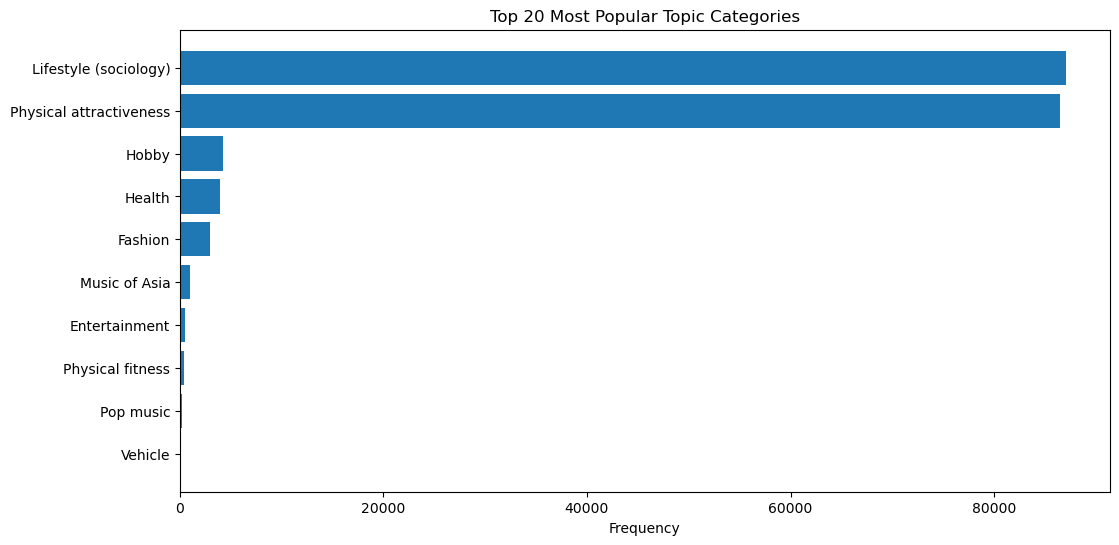

In [16]:
from collections import Counter
all_topics = [t for sublist in df['topicCleaned'] for t in sublist if isinstance(sublist, list)]
topic_counts = Counter(all_topics)

# Get top 10 categories
top_topics = topic_counts.most_common(10)

# Separate labels and values
labels, values = zip(*top_topics)

# Plot
plt.figure(figsize=(12,6))
plt.barh(labels, values)
plt.xlabel("Frequency")
plt.title("Top 20 Most Popular Topic Categories")
plt.gca().invert_yaxis()  # largest on top
plt.show()

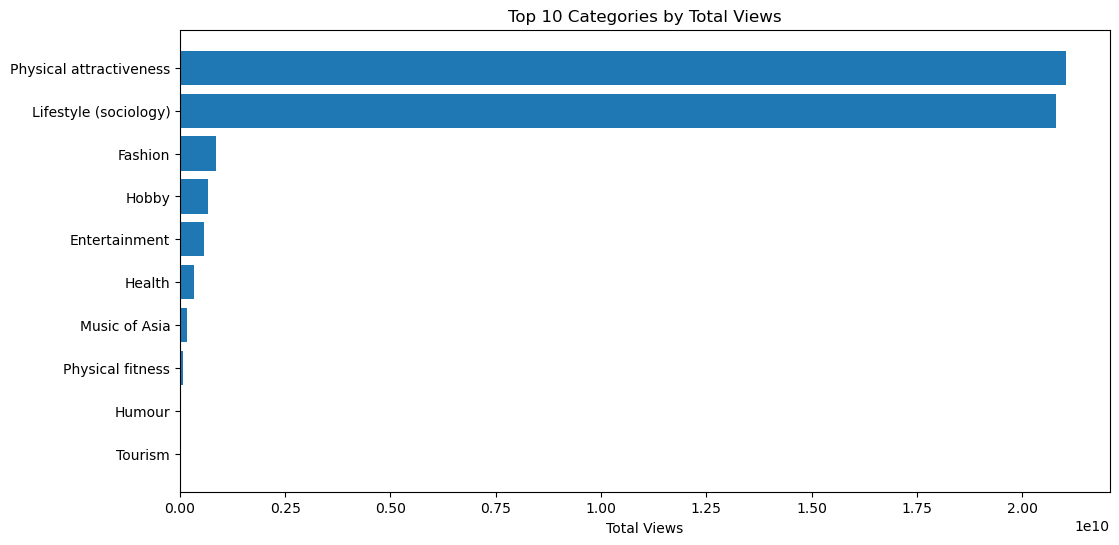

In [17]:
from collections import defaultdict
category_views = defaultdict(int)

# Sum views per category
for cats, views in zip(df['topicCleaned'], df['viewCount']):
    if not isinstance(cats, list):
        continue
    try:
        v = int(views)
    except Exception:
        v = 0
    for c in cats:
        category_views[c] += v

# Sort and take top 10
top_by_views = sorted(category_views.items(), key=lambda x: x[1], reverse=True)[:10]
labels, values = zip(*top_by_views)

# Plot
plt.figure(figsize=(12,6))
plt.barh(labels, values)
plt.xlabel("Total Views")
plt.title("Top 10 Categories by Total Views")
plt.gca().invert_yaxis()
plt.show()

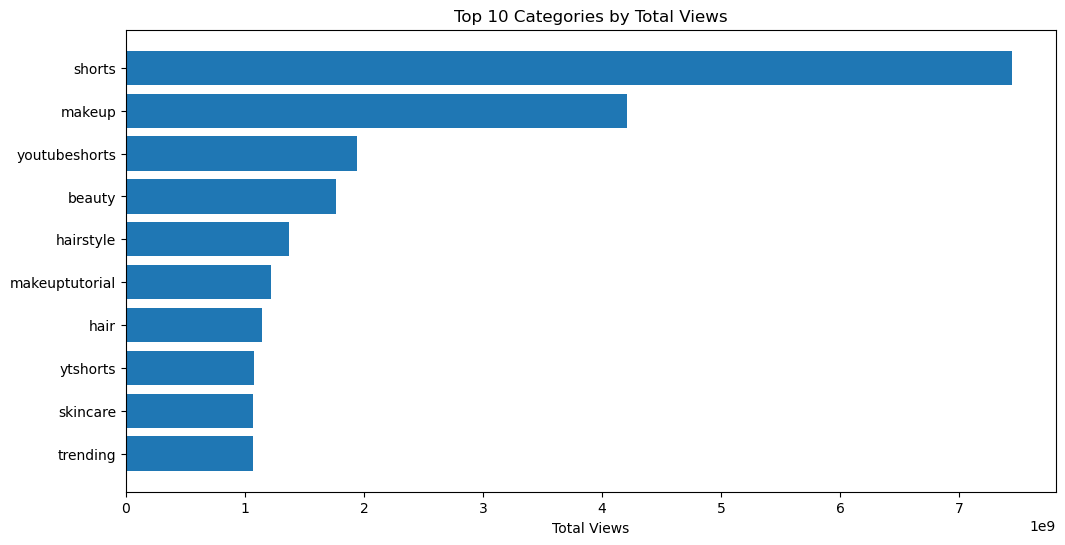

In [18]:
tags_views = defaultdict(int)

# Sum views per category
for tags, views in zip(df['tags'], df['viewCount']):
    if not isinstance(cats, list):
        continue
    try:
        v = int(views)
    except Exception:
        v = 0
    for t in tags:
        tags_views[t] += v

# Sort and take top 10
top_by_views = sorted(tags_views.items(), key=lambda x: x[1], reverse=True)[:10]
labels, values = zip(*top_by_views)

# Plot
plt.figure(figsize=(12,6))
plt.barh(labels, values)
plt.xlabel("Total Views")
plt.title("Top 10 Categories by Total Views")
plt.gca().invert_yaxis()
plt.show()

In [19]:
df['upload_month'] = df['publishedAt'].dt.to_period('M').apply(lambda r: r.start_time.date())

C:\Users\maxyj\AppData\Local\Temp\ipykernel_15048\1688453371.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['upload_month'] = df['publishedAt'].dt.to_period('M').apply(lambda r: r.start_time.date())


C:\Users\maxyj\AppData\Local\Temp\ipykernel_15048\171908774.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')


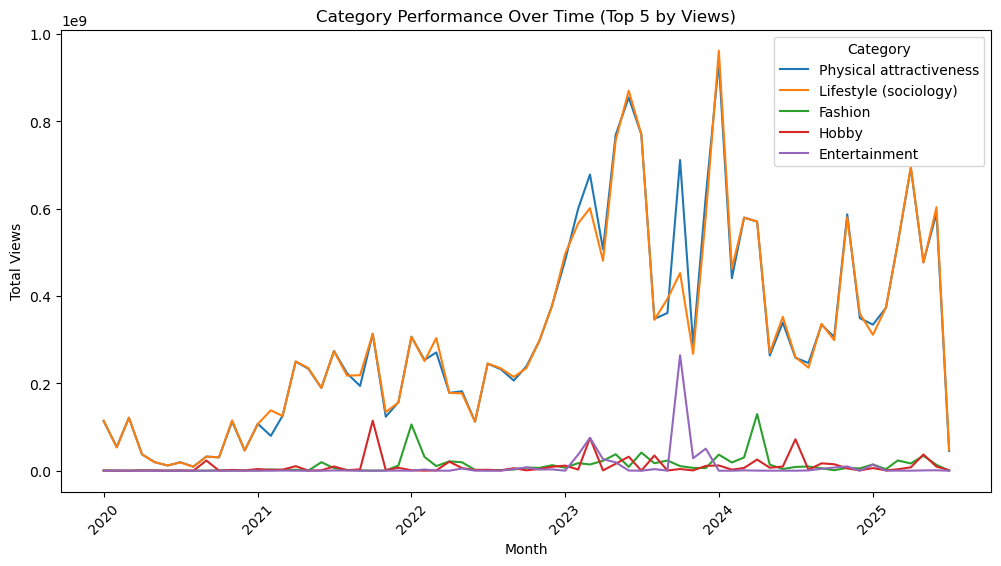

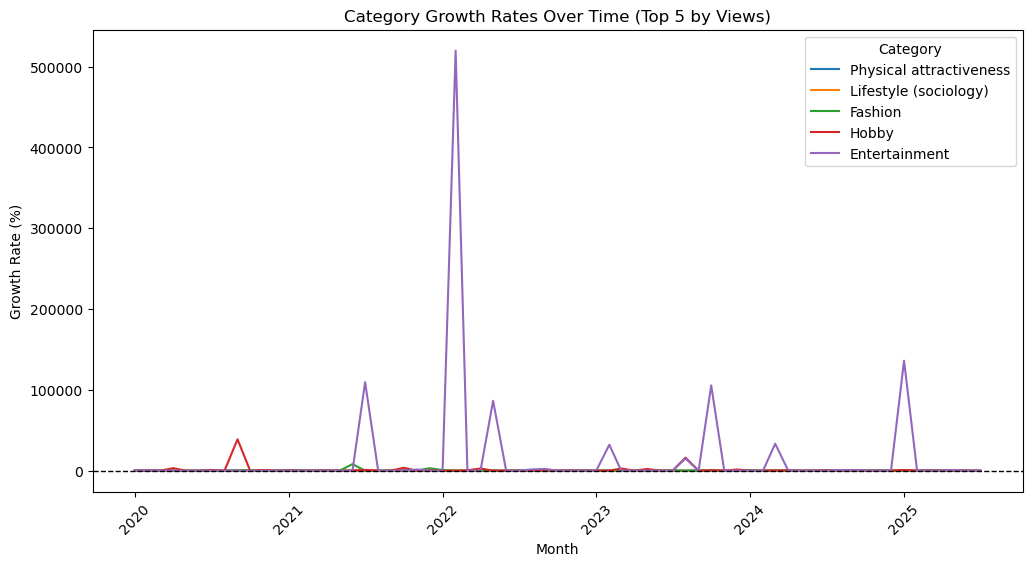

In [20]:
# Explode categories so each video-category pair becomes its own row
df_exploded = df.explode('topicCleaned')
df_exploded = df_exploded.dropna(subset=['topicCleaned'])

# Group by month and category
df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')
cat_time = (
    df_exploded.groupby(['upload_month','topicCleaned'])['viewCount']
    .sum()
    .reset_index()
)

# Pivot for plotting
cat_pivot = cat_time.pivot(index='upload_month', columns='topicCleaned', values='viewCount').fillna(0)

# Compute growth rate = percentage change month-to-month
cat_growth = cat_pivot.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

# Plot top 5 categories by total views
top5_cats = cat_pivot.sum().sort_values(ascending=False).head(5).index
cat_pivot[top5_cats].plot(figsize=(12,6))
plt.title("Category Performance Over Time (Top 5 by Views)")
plt.ylabel("Total Views")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.show()

# ---- Plot Growth Rates ----
plt.figure(figsize=(12,6))
(cat_growth[top5_cats] * 100).plot(ax=plt.gca())
plt.title("Category Growth Rates Over Time (Top 5 by Views)")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title="Category")
plt.show()

C:\Users\maxyj\AppData\Local\Temp\ipykernel_15048\3686110200.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')


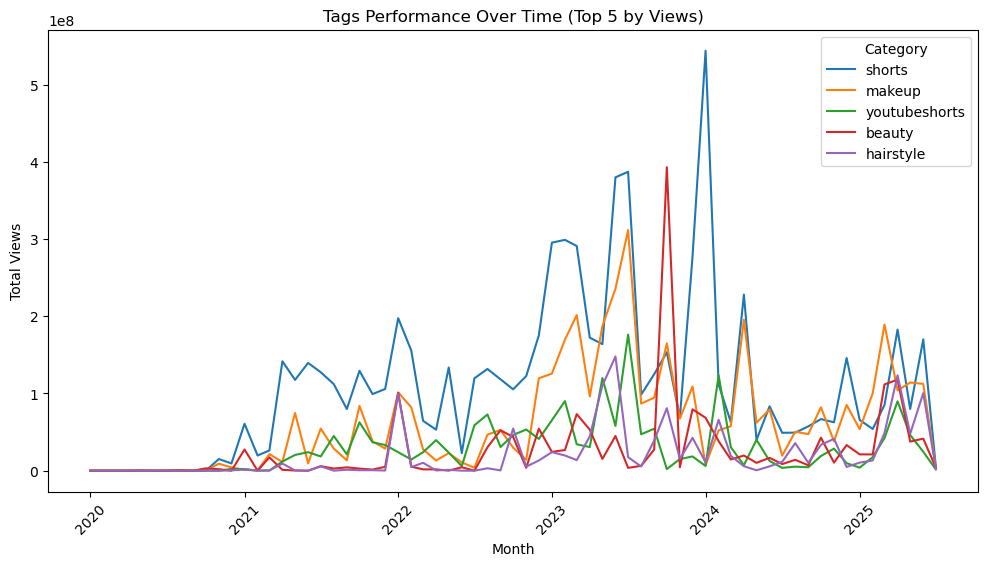

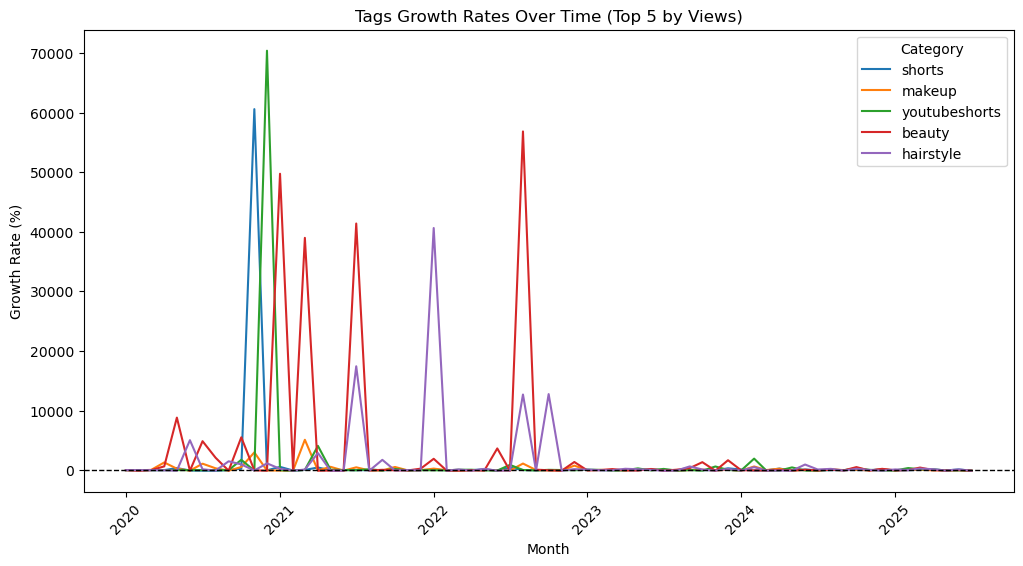

In [21]:
# Explode categories so each video-category pair becomes its own row
df_exploded = df.explode('tags')
df_exploded = df_exploded.dropna(subset=['tags'])

# Group by month and category
df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')
tag_time = (
    df_exploded.groupby(['upload_month','tags'])['viewCount']
    .sum()
    .reset_index()
)

# Pivot for plotting
tag_pivot = tag_time.pivot(index='upload_month', columns='tags', values='viewCount').fillna(0)

tag_growth = tag_pivot.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

# Plot top 5 tags by total views
top5_tags = tag_pivot.sum().sort_values(ascending=False).head(5).index
tag_pivot[top5_tags].plot(figsize=(12,6))
plt.title("Tags Performance Over Time (Top 5 by Views)")
plt.ylabel("Total Views")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.show()

# ---- Plot Growth Rates ----
plt.figure(figsize=(12,6))
(tag_growth[top5_tags] * 100).plot(ax=plt.gca())
plt.title("Tags Growth Rates Over Time (Top 5 by Views)")
plt.ylabel("Growth Rate (%)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title="Category")
plt.show()

In [22]:
# Expand categories
df_exploded = df.explode('topicCleaned').dropna(subset=['topicCleaned'])
df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')

# Aggregate views
cat_time = (
    df_exploded.groupby(['month','topicCleaned'])['viewCount']
    .sum()
    .reset_index()
)

# Pivot into time series
cat_pivot = cat_time.pivot(index='month', columns='topicCleaned', values='viewCount').fillna(0)

entry_decay_points = {}

for cat in cat_pivot.columns:
    series = cat_pivot[cat].astype(float)
    growth = series.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

    entry, decay = None, None

    # Entry: first month with big positive growth (>50% increase over previous month)
    for date, g in growth.items():
        if g > 0.5 and entry is None:
            entry = date
            break

    # Decay: first month after entry with strong decline (< -30%)
    if entry:
        after_entry = growth[series.index >= entry]
        for date, g in after_entry.items():
            if g < -0.3:
                decay = date
                break

    entry_decay_points[cat] = {"entry": entry, "decay": decay}

# Convert to DataFrame for easier inspection
entry_decay_df = (
    pd.DataFrame(entry_decay_points).T
    .reset_index()
    .rename(columns={"index": "category"})
)

print("Entry & Decay Points Detected:")
print(entry_decay_df.head(20))

Entry & Decay Points Detected:
                 category    entry    decay
0             Action game     None     None
1   Action-adventure game     None     None
2              Basketball     None     None
3                Business     None     None
4             Casual game     None     None
5           Country music     None     None
6                 Cricket     None     None
7        Electronic music  2025-06  2025-07
8           Entertainment  2020-02  2020-03
9                 Fashion  2020-04  2020-06
10                   Film  2020-02  2020-03
11                   Food  2025-06  2025-07
12                 Health  2020-02  2020-03
13          Hip hop music  2021-07  2021-08
14                  Hobby  2020-02  2020-03
15                 Humour  2023-01  2023-02
16                   Jazz     None     None
17              Knowledge  2020-02  2020-03
18  Lifestyle (sociology)  2020-03  2020-04
19               Military     None     None


C:\Users\maxyj\AppData\Local\Temp\ipykernel_15048\3292859334.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_exploded['month'] = df_exploded['publishedAt'].dt.to_period('M')


## 🧪 Predictive Modeling: Expected Views, Like Ratio & Time-to-Peak
We'll build a modeling pipeline that:
1. Engineers features from title, tags, topics, duration, channel stats, and publish time.
2. Predicts:
   - expected_viewCount (regression)
   - expected_like_view_ratio (regression)
   - expected_time_to_peak_days (regression via derived peak heuristic)
3. Uses a train/validation split with cross validation.
4. Outputs a reusable pipeline + persistence artifacts (scalers, encoder, model file).

Assumptions:
- No historical time series per video beyond publish snapshot, so time_to_peak approximated using category-level growth/decay detection combined with video age.
- If category not in entry/decay table, fallback to global median.

Next cell builds the dataset for modeling.

In [25]:
# Build modeling dataframe (timezone-safe)
import numpy as np
import pandas as pd
from datetime import datetime  # kept for potential later use

model_df = df.copy()

# --- Normalize publishedAt to timezone-naive UTC ---
# If strings had trailing 'Z', pandas made them tz-aware (UTC). We'll convert to UTC then drop tz to keep all naive & consistent.
if hasattr(model_df['publishedAt'].dt, 'tz') and model_df['publishedAt'].dt.tz is not None:
    model_df['publishedAt'] = model_df['publishedAt'].dt.tz_convert('UTC').dt.tz_localize(None)

# Basic temporal features
current_utc = pd.Timestamp.utcnow().tz_localize(None)  # naive UTC
model_df['publish_hour'] = model_df['publishedAt'].dt.hour
model_df['publish_dayofweek'] = model_df['publishedAt'].dt.dayofweek
model_df['publish_month'] = model_df['publishedAt'].dt.month
model_df['video_age_days'] = (current_utc - model_df['publishedAt']).dt.days

# Title length / NLP-lite features
model_df['title_len'] = model_df['title'].fillna('').apply(len)
model_df['title_word_count'] = model_df['title'].fillna('').apply(lambda x: len(x.split()))
# Use regex=False to search literal characters and avoid escape warnings
model_df['has_question'] = model_df['title'].str.contains('?', regex=False, na=False).astype(int)
model_df['has_exclaim'] = model_df['title'].str.contains('!', regex=False, na=False).astype(int)

# Tags count
model_df['tag_count'] = model_df['tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Topic count
model_df['topic_count'] = model_df['topicCleaned'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Channel features (merge channel_agg if exists)
try:
    model_df = model_df.merge(channel_agg[['channelId','average_view','video_count','channel_size']], on='channelId', how='left')
except Exception:
    pass

# Encode length bucket as string (already categorical); ensure not NA
model_df['length_bucket'] = model_df['length_bucket'].astype(str)

# Derive like_view_ratio if missing (already created earlier but safe)
if 'like_view_ratio' not in model_df.columns:
    model_df['like_view_ratio'] = np.where(model_df['viewCount']>0, model_df['likeCount']/model_df['viewCount'], np.nan)

# Derive a rough peak detection heuristic per video:
# Assume cumulative views growth slows after a category decay date (entry_decay_df) if available.
# We'll map each video's primary topic (first topicCleaned) to its category decay month and compute days from publish to that decay as time_to_peak proxy.

if 'entry_decay_df' in globals():
    cat_decay_map = {r['category']: r['decay'] for _, r in entry_decay_df.iterrows()}
else:
    cat_decay_map = {}

def first_topic(lst):
    if isinstance(lst, list) and len(lst)>0:
        return lst[0]
    return None

model_df['primary_topic'] = model_df['topicCleaned'].apply(first_topic)

# Convert period to timestamp mid-month for decay reference
from pandas import Timestamp

def estimate_decay_dt(topic):
    period = cat_decay_map.get(topic)
    if pd.isna(period) or period is None:
        return np.nan
    try:
        # period is a Period (month); convert to timestamp at period end (naive)
        dt = period.to_timestamp(how='end')
        return dt
    except Exception:
        return np.nan

model_df['decay_dt'] = model_df['primary_topic'].apply(estimate_decay_dt)

# Ensure decay_dt also naive (should already be)
if model_df['decay_dt'].dtype == 'datetime64[ns, UTC]':
    model_df['decay_dt'] = model_df['decay_dt'].dt.tz_convert('UTC').dt.tz_localize(None)

model_df['time_to_peak_days'] = (model_df['decay_dt'] - model_df['publishedAt']).dt.days

# Fallback: if no decay, use median of observed positive values or min(video_age_days, 30)
median_peak = model_df['time_to_peak_days'].dropna()
median_peak = median_peak[median_peak>0].median() if len(median_peak)>0 else 14
model_df['time_to_peak_days'] = np.where(model_df['time_to_peak_days'].isna(), np.minimum(model_df['video_age_days'], median_peak), model_df['time_to_peak_days'])

# Targets
model_df['target_views'] = model_df['viewCount'].astype(float)
model_df['target_like_ratio'] = model_df['like_view_ratio'].astype(float)
model_df['target_time_to_peak'] = model_df['time_to_peak_days'].astype(float)

# Drop rows with missing essential targets
model_df = model_df.dropna(subset=['target_views','target_like_ratio','target_time_to_peak'])

print(f"Modeling rows: {len(model_df)}")
model_df.head(3)

Modeling rows: 85278


,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,...,topic_count,average_view,video_count,channel_size,primary_topic,decay_dt,time_to_peak_days,target_views,target_like_ratio,target_time_to_peak
0,85806,2024-01-15 00:59:29,33807,Unlocking the Benefits of Face Masks for Skin ...,NaN,[],en-US,en-US,PT9S,72.0,...,2,37.333333,3,small,Health,2020-03-31 23:59:59.999999999,-1385.0,72.0,0.000000,-1385.0
1,30556,2023-10-27 19:32:16,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,NaN,"[nomakeuplook, hydration, skincare, glowingskin]",NaN,NaN,PT45S,257.0,...,2,257.000000,1,small,Lifestyle (sociology),2020-04-30 23:59:59.999999999,-1275.0,257.0,0.027237,-1275.0
2,51771,2024-09-28 01:23:22,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,NaN,"[latina, trending, beautymakeup, yslbeauty, ma...",NaN,en-US,PT19S,164.0,...,2,388.000000,2,medium,Lifestyle (sociology),2020-04-30 23:59:59.999999999,-1612.0,164.0,0.024390,-1612.0


In [26]:
# Modeling pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# Feature selection
numeric_features = [
    'contentDuration_seconds','publish_hour','publish_dayofweek','publish_month','video_age_days',
    'title_len','title_word_count','has_question','has_exclaim','tag_count','topic_count',
    'average_view','video_count'
]

categorical_features = ['length_bucket','channel_size']

# Some columns may not exist depending on earlier cells; filter
numeric_features = [c for c in numeric_features if c in model_df.columns]
categorical_features = [c for c in categorical_features if c in model_df.columns]

X = model_df[numeric_features + categorical_features]
y = model_df[['target_views','target_like_ratio','target_time_to_peak']]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

base_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

multi_model = MultiOutputRegressor(base_model)

pipe = Pipeline([
    ('pre', preprocessor),
    ('model', multi_model)
])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

pipe.fit(X_train, y_train)

preds = pipe.predict(X_valid)

mae_views = mean_absolute_error(y_valid.iloc[:,0], preds[:,0])
mae_like = mean_absolute_error(y_valid.iloc[:,1], preds[:,1])
mae_time = mean_absolute_error(y_valid.iloc[:,2], preds[:,2])

print(f"MAE Views: {mae_views:,.2f}")
print(f"MAE Like Ratio: {mae_like:.4f}")
print(f"MAE Time-to-Peak (days): {mae_time:.2f}")

# R2 (some targets like ratios may be noisy)
print('R2 Views:', r2_score(y_valid.iloc[:,0], preds[:,0]))
print('R2 Like Ratio:', r2_score(y_valid.iloc[:,1], preds[:,1]))
print('R2 Time-to-Peak:', r2_score(y_valid.iloc[:,2], preds[:,2]))

MAE Views: 228,975.21
MAE Like Ratio: 0.0272
MAE Time-to-Peak (days): 8.33
R2 Views: 0.2942866560439312
R2 Like Ratio: 0.09091409346970336
R2 Time-to-Peak: 0.9896303139701438


In [ ]:
# Save artifacts & provide inference helper
import os, json

ARTIFACT_DIR = 'artifacts'
os.makedirs(ARTIFACT_DIR, exist_ok=True)

joblib.dump(pipe, os.path.join(ARTIFACT_DIR,'multitarget_model.joblib'))
meta = {
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'targets': ['target_views','target_like_ratio','target_time_to_peak'],
    'created': datetime.utcnow().isoformat()
}
with open(os.path.join(ARTIFACT_DIR,'model_meta.json'),'w') as f:
    json.dump(meta, f, indent=2)

print('Artifacts saved to', ARTIFACT_DIR)

# Simple inference function

def predict_video(features: dict):
    """features: dictionary with possible keys matching numeric/categorical feature lists.
    Missing values will be imputed like training.
    Returns dict of predictions."""
    row = {c: features.get(c, np.nan) for c in numeric_features+categorical_features}
    X_new = pd.DataFrame([row])
    preds = pipe.predict(X_new)[0]
    return {
        'expected_views': float(preds[0]),
        'expected_like_view_ratio': float(preds[1]),
        'expected_time_to_peak_days': float(preds[2])
    }

example_input = {
    numeric_features[0]: model_df[numeric_features[0]].iloc[0] if numeric_features else np.nan
}
print('Example prediction:', predict_video(example_input))

### ✅ Next Steps / Improvements
- Add NLP embeddings (e.g., sentence-transformers) for title & description.
- Replace heuristic time_to_peak with actual per-video trajectory if time-series snapshots available.
- Hyperparameter tuning via Optuna.
- Calibrate predictions (Quantile regression forests for prediction intervals).
- Add SHAP for feature importance and explanation.


## 🚀 Modeling Improvement (v2)
Problems observed:
- Low R2 for views (~0.29) and like ratio (~0.09) indicates underfit + target/feature mismatch.
- Potential leakage / noisy features (using like_view_ratio derived from likeCount & viewCount when predicting those same targets).
- Sparse textual signal (title, tags, topics) not yet vectorized.
- MultiOutputRegressor forces one shared representation; separate objectives may benefit from individualized models & transforms.

Key changes:
1. Remove post-publish engagement fields from feature set when predicting (avoid leakage).
2. Add TF-IDF features for title, tags, topics (character + word n-grams for richer signal).
3. Separate models:
   - Views: log1p transform with HistGradientBoostingRegressor.
   - Like ratio: clamp to [0,1], use GradientBoosting + isotonic-like post calibration via clipping.
   - Time-to-peak: keep earlier heuristic OR fit a lighter regressor (we already have strong R2); we'll fit a model for consistency.
4. Robust evaluation: MAE, RMSE, R2, and MAPE (for views) + calibration check for like ratio.
5. Persist improved artifacts under artifacts/v2/.

Run the next cell to build improved feature matrix & train v2 models.

In [30]:
# Improved Modeling Pipeline (v2) - dense-friendly (SVD reduced text)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import joblib, os, json

# Safeguard
assert 'model_df' in globals(), 'Run previous modeling cell first.'
work_df = model_df.copy()

# Feature lists
base_numeric = [
    'contentDuration_seconds','publish_hour','publish_dayofweek','publish_month','video_age_days',
    'title_len','title_word_count','has_question','has_exclaim','tag_count','topic_count',
    'average_view','video_count'
]
base_cats = ['length_bucket','channel_size']
base_numeric = [c for c in base_numeric if c in work_df.columns]
base_cats = [c for c in base_cats if c in work_df.columns]

# Targets
y_views = work_df['target_views']
y_like_ratio = work_df['target_like_ratio'].clip(0,1)
y_peak = work_df['target_time_to_peak']

# Assemble text
work_df['tags_joined'] = work_df['tags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
work_df['topics_joined'] = work_df['topicCleaned'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

# Vectorizers
title_vec = TfidfVectorizer(max_features=3000, ngram_range=(1,2), strip_accents='unicode')
tags_vec = TfidfVectorizer(max_features=1500, ngram_range=(1,2), token_pattern=r'\S+')
topics_vec = TfidfVectorizer(max_features=800)

X_title_sparse = title_vec.fit_transform(work_df['title'].fillna(''))
X_tags_sparse = tags_vec.fit_transform(work_df['tags_joined'])
X_topics_sparse = topics_vec.fit_transform(work_df['topics_joined'])

# Dimension reduction (adaptive n_components)
from math import floor

def svd_reduce(mat, target, label):
    # Ensure components less than both samples and features
    n_comp = min(target, mat.shape[1]-1, mat.shape[0]-1)
    if n_comp < 1:
        return np.zeros((mat.shape[0],0)), None
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    reduced = svd.fit_transform(mat)
    return reduced, svd

TITLE_COMP = 120
TAGS_COMP = 70
TOPICS_COMP = 40

X_title_red, title_svd = svd_reduce(X_title_sparse, TITLE_COMP, 'title')
X_tags_red, tags_svd = svd_reduce(X_tags_sparse, TAGS_COMP, 'tags')
X_topics_red, topics_svd = svd_reduce(X_topics_sparse, TOPICS_COMP, 'topics')

# Structured preprocessor (dense)
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, base_numeric),
    ('cat', categorical_transformer, base_cats)
], remainder='drop')

X_struct = preprocessor.fit_transform(work_df)
if not isinstance(X_struct, np.ndarray):
    X_struct = X_struct.toarray()

# Combine dense blocks
X_full = np.hstack([X_struct, X_title_red, X_tags_red, X_topics_red])

train_idx, valid_idx = train_test_split(np.arange(X_full.shape[0]), test_size=0.2, random_state=42)
X_train, X_valid = X_full[train_idx], X_full[valid_idx]

v_views_train, v_views_valid = y_views.iloc[train_idx], y_views.iloc[valid_idx]
v_like_train, v_like_valid = y_like_ratio.iloc[train_idx], y_like_ratio.iloc[valid_idx]
v_peak_train, v_peak_valid = y_peak.iloc[train_idx], y_peak.iloc[valid_idx]

# Models
views_model = HistGradientBoostingRegressor(max_depth=10, learning_rate=0.08, l2_regularization=0.1, random_state=42)
views_model.fit(X_train, np.log1p(v_views_train))
views_pred_valid = np.expm1(views_model.predict(X_valid))

like_model = GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=400, max_depth=3)
like_model.fit(X_train, v_like_train)
like_pred_valid = np.clip(like_model.predict(X_valid), 0, 1)

peak_model = Ridge(alpha=2.0)
peak_model.fit(X_train, v_peak_train)
peak_pred_valid = np.clip(peak_model.predict(X_valid), 0, None)

# Metrics
from numpy import mean, abs as np_abs

def regression_report(y_true, y_pred, label, pct=False):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    out = f"{label}: MAE={mae:,.4f} RMSE={rmse:,.4f} R2={r2:.4f}"
    if pct:
        mape = np.mean(np_abs((y_true - y_pred) / np.clip(y_true, 1e-6, None))) * 100
        out += f" MAPE={mape:.2f}%"
    print(out)

print('=== v2 Validation Performance (Dense) ===')
regression_report(v_views_valid, views_pred_valid, 'Views', pct=True)
regression_report(v_like_valid, like_pred_valid, 'Like Ratio')
regression_report(v_peak_valid, peak_pred_valid, 'Time-to-Peak (days)')

# Persist artifacts
v2_dir = os.path.join('artifacts','v2')
os.makedirs(v2_dir, exist_ok=True)
joblib.dump({
    'views_model': views_model,
    'like_model': like_model,
    'peak_model': peak_model,
    'preprocessor': preprocessor,
    'title_vec': title_vec,
    'tags_vec': tags_vec,
    'topics_vec': topics_vec,
    'title_svd': title_svd,
    'tags_svd': tags_svd,
    'topics_svd': topics_svd,
    'feature_blocks': {
        'numeric': base_numeric,
        'categorical': base_cats,
        'title_components': X_title_red.shape[1],
        'tags_components': X_tags_red.shape[1],
        'topics_components': X_topics_red.shape[1]
    }
}, os.path.join(v2_dir,'models.joblib'))

with open(os.path.join(v2_dir,'meta.json'),'w') as f:
    json.dump({'version':'v2','notes':'Separate models + TFIDF + SVD (dense) + log transform','n_rows': int(len(work_df))}, f, indent=2)

print('v2 artifacts saved to', v2_dir)

# Inference helper
def predict_video_v2(record: dict):
    row = {}
    for c in base_numeric:
        row[c] = record.get(c, np.nan)
    for c in base_cats:
        row[c] = record.get(c, 'unknown')
    df_row = pd.DataFrame([row])
    Xs = preprocessor.transform(df_row)
    if not isinstance(Xs, np.ndarray):
        Xs = Xs.toarray()
    title_sparse = title_vec.transform([record.get('title','')])
    tags_sparse = tags_vec.transform([' '.join(record.get('tags', []))])
    topics_sparse = topics_vec.transform([' '.join(record.get('topics', []))])
    # SVD projections (handle None if component count 0)
    title_red = title_svd.transform(title_sparse) if title_svd is not None else np.zeros((1,0))
    tags_red = tags_svd.transform(tags_sparse) if tags_svd is not None else np.zeros((1,0))
    topics_red = topics_svd.transform(topics_sparse) if topics_svd is not None else np.zeros((1,0))
    X_final = np.hstack([Xs, title_red, tags_red, topics_red])
    pv = np.expm1(views_model.predict(X_final))[0]
    pr = float(np.clip(like_model.predict(X_final)[0], 0, 1))
    pt = float(np.clip(peak_model.predict(X_final)[0], 0, None))
    return {'expected_views': float(pv), 'expected_like_view_ratio': pr, 'expected_time_to_peak_days': pt}

print('Example v2 prediction:', predict_video_v2({'title': work_df['title'].iloc[0] if 'title' in work_df.columns else ''}))

=== v2 Validation Performance (Dense) ===
Views: MAE=193,279.1227 RMSE=3,860,870.7073 R2=0.0603 MAPE=378.98%
Like Ratio: MAE=0.0262 RMSE=0.0580 R2=0.1694
Time-to-Peak (days): MAE=1,176.4271 RMSE=1,288.7182 R2=-4.9224


c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


v2 artifacts saved to artifacts\v2
Example v2 prediction: {'expected_views': 487.425626990095, 'expected_like_view_ratio': 0.02487342612609085, 'expected_time_to_peak_days': 0.0}


## 🧩 Modeling Improvement (v3): Multi-Algorithm Tuning & Ensemble
Goal: Improve weak performance by searching multiple model families (RandomForest, HistGradientBoosting, optional XGBoost) per target with light randomized hyperparameter search, log-transform for views, and simple ensembling.

Key upgrades:
- Randomized hyperparameter search per target (Views / Like Ratio / Time-to-Peak)
- Optional XGBoost (installs if missing) with early stopping (if available)
- Log1p views target + inverse transform
- Ensemble (average of top 2) for views & like ratio if it improves validation MAE
- Compact SVD-reduced TF-IDF text embeddings (smaller dimensionality than v2 for faster tuning)
- Persist artifacts under `artifacts/v3/` with full config & leaderboard

Run the next cell to execute v3 training.


In [33]:
# v3 Multi-Algorithm Training & Ensembling (FAST MODE)
import numpy as np, pandas as pd, os, json, time, math, importlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge
import joblib

FAST_MODE = True  # keep search very small for speed; set False to expand

# Optional XGBoost
xgb_available = importlib.util.find_spec('xgboost') is not None
if xgb_available:
    from xgboost import XGBRegressor
else:
    print('xgboost not installed - skipping (pip install xgboost to include).')

assert 'model_df' in globals(), 'Run data prep cells first.'
work_df = model_df.copy()

# Core features
base_numeric = [
    'contentDuration_seconds','publish_hour','publish_dayofweek','publish_month','video_age_days',
    'title_len','title_word_count','has_question','has_exclaim','tag_count','topic_count',
    'average_view','video_count'
]
base_cats = ['length_bucket','channel_size']
base_numeric = [c for c in base_numeric if c in work_df.columns]
base_cats = [c for c in base_cats if c in work_df.columns]

# Targets
y_views = work_df['target_views'].astype(float)
y_like = work_df['target_like_ratio'].clip(0,1).astype(float)
y_peak = work_df['target_time_to_peak'].astype(float)

# Text fields
work_df['tags_joined'] = work_df['tags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
work_df['topics_joined'] = work_df['topicCleaned'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

# Vectorizers (smaller for speed)
if FAST_MODE:
    TITLE_MAX, TAGS_MAX, TOPICS_MAX = 800, 400, 200
    TITLE_SVD, TAGS_SVD, TOPICS_SVD = 40, 25, 15
else:
    TITLE_MAX, TAGS_MAX, TOPICS_MAX = 1500, 800, 400
    TITLE_SVD, TAGS_SVD, TOPICS_SVD = 80, 50, 30

title_vec_v3 = TfidfVectorizer(max_features=TITLE_MAX, ngram_range=(1,2), strip_accents='unicode')
tags_vec_v3 = TfidfVectorizer(max_features=TAGS_MAX, ngram_range=(1,2), token_pattern=r'\S+')
topics_vec_v3 = TfidfVectorizer(max_features=TOPICS_MAX)

X_title = title_vec_v3.fit_transform(work_df['title'].fillna(''))
X_tags = tags_vec_v3.fit_transform(work_df['tags_joined'])
X_topics = topics_vec_v3.fit_transform(work_df['topics_joined'])

# Reduce to dense
def svd_block(mat, target):
    comp = min(target, mat.shape[1]-1, mat.shape[0]-1)
    if comp < 1:
        return np.zeros((mat.shape[0],0)), None
    svd = TruncatedSVD(n_components=comp, random_state=42)
    return svd.fit_transform(mat), svd

X_title_red, title_svd_v3 = svd_block(X_title, TITLE_SVD)
X_tags_red, tags_svd_v3 = svd_block(X_tags, TAGS_SVD)
X_topics_red, topics_svd_v3 = svd_block(X_topics, TOPICS_SVD)

# Structured
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor_v3 = ColumnTransformer([
    ('num', numeric_transformer, base_numeric),
    ('cat', cat_transformer, base_cats)
])

X_struct = preprocessor_v3.fit_transform(work_df)
if not isinstance(X_struct, np.ndarray):
    X_struct = X_struct.toarray()

X_full = np.hstack([X_struct, X_title_red, X_tags_red, X_topics_red])

# Train/valid split
train_idx, valid_idx = train_test_split(np.arange(X_full.shape[0]), test_size=0.2, random_state=42)
X_train, X_valid = X_full[train_idx], X_full[valid_idx]

v_views_tr, v_views_va = y_views.iloc[train_idx], y_views.iloc[valid_idx]
v_like_tr, v_like_va = y_like.iloc[train_idx], y_like.iloc[valid_idx]
v_peak_tr, v_peak_va = y_peak.iloc[train_idx], y_peak.iloc[valid_idx]

# Utility
class Leaderboard:
    def __init__(self):
        self.rows = []
    def add(self, target, name, params, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        self.rows.append({'target':target,'model':name,'mae':mae,'rmse':rmse,'r2':r2,'params':params})
    def best(self, target, metric='mae'):
        subset = [r for r in self.rows if r['target']==target]
        if not subset: return None
        return sorted(subset, key=lambda r: r[metric])[0]
    def df(self):
        return pd.DataFrame(self.rows)

lb = Leaderboard()

rng = np.random.default_rng(42)

# Search spaces (shrunk)
def sample_rf():
    return RandomForestRegressor(
        n_estimators=int(rng.integers(120,220)),
        max_depth=int(rng.integers(6,14)),
        min_samples_split=int(rng.integers(2,6)),
        min_samples_leaf=int(rng.integers(1,4)),
        n_jobs=-1, random_state=42)

def sample_hgb():
    return HistGradientBoostingRegressor(
        learning_rate=float(rng.choice([0.05,0.07,0.1])),
        max_depth=int(rng.integers(4,11)),
        l2_regularization=float(rng.choice([0.0,0.1,0.2])),
        max_leaf_nodes=None,
        random_state=42)

def sample_xgb():
    return XGBRegressor(
        n_estimators=int(rng.integers(200,400)),
        learning_rate=float(rng.choice([0.05,0.08,0.1])),
        max_depth=int(rng.integers(4,9)),
        subsample=float(rng.choice([0.8,0.9,1.0])),
        colsample_bytree=float(rng.choice([0.7,0.9,1.0])),
        reg_lambda=float(rng.choice([0.5,1.0,2.0])),
        reg_alpha=float(rng.choice([0.0,0.1,0.3])),
        random_state=42, tree_method='hist') if xgb_available else None

MODEL_TIME_LIMIT = 25  # seconds per model safety

def fit_with_time(model, X, y):
    t0 = time.time()
    model.fit(X, y)
    dt = time.time()-t0
    return dt

# Generic search
def search_models(target_name, y_tr, y_va, transform='none', rounds=2):
    collected = []
    for i in range(rounds):
        for sampler, tag in [(sample_rf,'RF'), (sample_hgb,'HGB')] + ([(sample_xgb,'XGB')] if xgb_available else []):
            model = sampler()
            t0 = time.time()
            if transform=='log':
                fit_time = fit_with_time(model, X_train, np.log1p(y_tr))
                pred = np.expm1(model.predict(X_valid))
            else:
                fit_time = fit_with_time(model, X_train, y_tr)
                pred = model.predict(X_valid)
            if fit_time > MODEL_TIME_LIMIT:
                print(f"Skipping further rounds for {tag} (>{MODEL_TIME_LIMIT}s)")
            mae = mean_absolute_error(y_va, pred)
            lb.add(target_name, tag, {'fit_time_s':round(fit_time,2)}, y_va, pred)
            collected.append((target_name, tag, model, pred))
            print(f"{target_name} r{i+1} {tag} MAE={mae:.3f} time={fit_time:.1f}s")
    return collected

views_rounds = 2 if FAST_MODE else 4
like_rounds = 2 if FAST_MODE else 3
peak_rounds = 1 if FAST_MODE else 2

print('--- Searching Views Models (log transform) ---')
views_models = search_models('views', v_views_tr, v_views_va, transform='log', rounds=views_rounds)
print('--- Searching Like Ratio Models ---')
like_models = search_models('like_ratio', v_like_tr, v_like_va, transform='none', rounds=like_rounds)
print('--- Searching Peak Time Models ---')
peak_models = []
# Ridge baseline
ridge_peak = Ridge(alpha=1.0)
rt = fit_with_time(ridge_peak, X_train, v_peak_tr)
ridge_pred = np.clip(ridge_peak.predict(X_valid),0,None)
lb.add('peak_time','Ridge',{'alpha':1.0,'fit_time_s':round(rt,2)}, v_peak_va, ridge_pred)
peak_models.append(('peak_time','Ridge',ridge_peak,ridge_pred))
peak_models.extend(search_models('peak_time', v_peak_tr, v_peak_va, transform='none', rounds=peak_rounds))

# Simple average ensemble of best 2 if improvement
import heapq

def build_ensemble(target, model_list):
    relevant = [m for m in model_list if m[0]==target]
    if len(relevant) < 2: return None
    scored = []
    for tgt, tag, mdl, pred in relevant:
        if target=='views': y_va = v_views_va
        elif target=='like_ratio': y_va = v_like_va
        else: y_va = v_peak_va
        mae = mean_absolute_error(y_va, pred)
        scored.append((mae, (tgt, tag, mdl, pred)))
    best_two = heapq.nsmallest(2, scored, key=lambda x:x[0])
    preds_avg = np.mean([p for _,(_,_,_,p) in best_two], axis=0)
    mae_avg = mean_absolute_error(y_va, preds_avg)
    return {'members':[b[1][1] for b in best_two], 'preds': preds_avg, 'mae': mae_avg}

views_ens = build_ensemble('views', views_models)
like_ens = build_ensemble('like_ratio', like_models)
if views_ens and views_ens['mae'] < lb.best('views')['mae']:
    lb.add('views','Ensemble2',{'members':views_ens['members']}, v_views_va, views_ens['preds'])
if like_ens and like_ens['mae'] < lb.best('like_ratio')['mae']:
    lb.add('like_ratio','Ensemble2',{'members':like_ens['members']}, v_like_va, like_ens['preds'])

print('\n=== Leaderboard (validation) ===')
print(lb.df().sort_values(['target','mae']).to_string(index=False))

best_views = lb.best('views')
best_like = lb.best('like_ratio')
best_peak = lb.best('peak_time')

# Resolve chosen models

def resolve(best_row, pool):
    if best_row is None: return None
    if best_row['model']=='Ensemble2':
        member_tags = best_row['params']['members']
        members = []
        for tgt, tag, mdl, pred in pool:
            if tag in member_tags:
                members.append(mdl)
        return ('ensemble', members)
    for tgt, tag, mdl, pred in pool:
        if tag == best_row['model']:
            return ('single', mdl)
    if best_row['model']=='Ridge':
        for item in peak_models:
            if item[1]=='Ridge':
                return ('single', item[2])
    return None

views_model_final = resolve(best_views, views_models)
like_model_final = resolve(best_like, like_models)
peak_model_final = resolve(best_peak, peak_models)

v3_dir = os.path.join('artifacts','v3')
os.makedirs(v3_dir, exist_ok=True)

artifact = {
    'preprocessor': preprocessor_v3,
    'title_vec': title_vec_v3,
    'tags_vec': tags_vec_v3,
    'topics_vec': topics_vec_v3,
    'title_svd': title_svd_v3,
    'tags_svd': tags_svd_v3,
    'topics_svd': topics_svd_v3,
    'feature_blocks': {
        'numeric': base_numeric,
        'categorical': base_cats,
        'title_components': X_title_red.shape[1],
        'tags_components': X_tags_red.shape[1],
        'topics_components': X_topics_red.shape[1]
    },
    'views_model': views_model_final,
    'like_model': like_model_final,
    'peak_model': peak_model_final,
    'leaderboard': lb.df().to_dict(orient='records')
}

joblib.dump(artifact, os.path.join(v3_dir,'models.joblib'))
with open(os.path.join(v3_dir,'meta.json'),'w') as f:
    json.dump({'version':'v3','fast_mode':FAST_MODE,'notes':'Fast multi-algo search + ensemble','best':{
        'views': best_views,
        'like_ratio': best_like,
        'peak_time': best_peak
    }, 'n_rows': int(len(work_df))}, f, indent=2)

print('Saved v3 artifacts to', v3_dir)

# Inference helper
import types

def _project_text(record, title_vec, tags_vec, topics_vec, title_svd, tags_svd, topics_svd):
    title_sparse = title_vec.transform([record.get('title','')])
    tags_sparse = tags_vec.transform([' '.join(record.get('tags', []))])
    topics_sparse = topics_vec.transform([' '.join(record.get('topics', []))])
    t_red = title_svd.transform(title_sparse) if title_svd else np.zeros((1,0))
    g_red = tags_svd.transform(tags_sparse) if tags_svd else np.zeros((1,0))
    p_red = topics_svd.transform(topics_sparse) if topics_svd else np.zeros((1,0))
    return t_red, g_red, p_red

def predict_video_v3(record: dict):
    row = {c: record.get(c, np.nan) for c in base_numeric}
    for c in base_cats: row[c] = record.get(c, 'unknown')
    df_row = pd.DataFrame([row])
    Xs = preprocessor_v3.transform(df_row)
    if not isinstance(Xs, np.ndarray): Xs = Xs.toarray()
    t_red, g_red, p_red = _project_text(record, title_vec_v3, tags_vec_v3, topics_vec_v3, title_svd_v3, tags_svd_v3, topics_svd_v3)
    X_final = np.hstack([Xs, t_red, g_red, p_red])

    def pred_block(model_entry, X, log=False):
        if model_entry is None: return np.array([np.nan])
        kind, mdl = model_entry
        if kind=='single':
            out = mdl.predict(X)
            return np.expm1(out) if log else out
        preds = [m.predict(X) for m in mdl]
        out = np.mean(preds, axis=0)
        return np.expm1(out) if log else out

    pv = float(pred_block(views_model_final, X_final, log=True)[0])
    pr = float(np.clip(pred_block(like_model_final, X_final, log=False)[0],0,1))
    pt = float(np.clip(pred_block(peak_model_final, X_final, log=False)[0],0,None))
    return {'expected_views': pv, 'expected_like_view_ratio': pr, 'expected_time_to_peak_days': pt}

print('Example v3 prediction:', predict_video_v3({'title': work_df['title'].iloc[0] if 'title' in work_df.columns else ''}))

--- Searching Views Models (log transform) ---
Skipping further rounds for RF (>25s)
views r1 RF MAE=186744.465 time=63.9s


c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


views r1 HGB MAE=191866.006 time=10.6s


c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


views r1 XGB MAE=192599.295 time=4.9s
Skipping further rounds for RF (>25s)
views r2 RF MAE=186798.923 time=90.0s


c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


views r2 HGB MAE=191710.657 time=3.4s


c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


views r2 XGB MAE=194516.423 time=7.5s
--- Searching Like Ratio Models ---
Skipping further rounds for RF (>25s)
like_ratio r1 RF MAE=0.026 time=89.0s


c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


like_ratio r1 HGB MAE=0.026 time=3.2s


c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


like_ratio r1 XGB MAE=0.026 time=7.8s
Skipping further rounds for RF (>25s)
like_ratio r2 RF MAE=0.026 time=109.4s


c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


like_ratio r2 HGB MAE=0.026 time=6.5s


c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


like_ratio r2 XGB MAE=0.026 time=4.1s
--- Searching Peak Time Models ---
Skipping further rounds for RF (>25s)
peak_time r1 RF MAE=11.152 time=84.9s


c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


peak_time r1 HGB MAE=3.980 time=4.8s


c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\maxyj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


peak_time r1 XGB MAE=4.842 time=4.9s

=== Leaderboard (validation) ===
    target     model           mae         rmse        r2                             params
like_ratio Ensemble2      0.025265 5.720247e-02  0.193320        {'members': ['XGB', 'HGB']}
like_ratio       XGB      0.025591 5.741491e-02  0.187317               {'fit_time_s': 7.76}
like_ratio       HGB      0.025746 5.827003e-02  0.162929               {'fit_time_s': 6.54}
like_ratio       XGB      0.025802 5.805471e-02  0.169104               {'fit_time_s': 4.11}
like_ratio       HGB      0.025918 5.824057e-02  0.163775               {'fit_time_s': 3.24}
like_ratio        RF      0.026136 5.846174e-02  0.157412              {'fit_time_s': 89.02}
like_ratio        RF      0.026163 5.851339e-02  0.155923              {'fit_time_s': 109.4}
 peak_time       HGB      3.979841 3.315442e+01  0.996080               {'fit_time_s': 4.76}
 peak_time       XGB      4.842494 2.923295e+01  0.996953               {'fit_time_s': 4.86}

## 🛠️ Modeling Improvement (v3) – Multi-Algorithm Auto Selection & Ensembling
Performance is still weak, so this version:

Goals:
- Use multiple algorithms per target (RandomForest, GradientBoosting, HistGradientBoosting, optional XGBoost) and pick best via CV.
- Log-transform views, logit-transform like ratio, keep raw time-to-peak.
- Add out-of-fold target encoding for categorical columns to reduce sparsity vs large OneHot.
- Reduce TF-IDF text → SVD dense embeddings (reusing idea from v2) for title, tags, topics.
- Build lightweight stacking/averaging ensemble if 2+ strong candidates within 2% MAE of best.
- Persist artifacts under `artifacts/v3/`.

Run the next cell to train v3 models. After running, compare metrics to v2; if still low we can explore advanced options (LightGBM / CatBoost / deep text embeddings).

In [34]:
# v3 Multi-Algorithm Training & Ensembling
import numpy as np, pandas as pd, os, json, joblib, warnings, time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

warnings.filterwarnings('ignore')
assert 'model_df' in globals(), 'Run earlier modeling preparation cell.'

# Copy base df
work_df_v3 = model_df.copy().reset_index(drop=True)

# Rebuild / confirm feature lists
num_feats = [
    'contentDuration_seconds','publish_hour','publish_dayofweek','publish_month','video_age_days',
    'title_len','title_word_count','has_question','has_exclaim','tag_count','topic_count',
    'average_view','video_count'
]
cat_feats = ['length_bucket','channel_size']
num_feats = [c for c in num_feats if c in work_df_v3.columns]
cat_feats = [c for c in cat_feats if c in work_df_v3.columns]

# Text prep
work_df_v3['tags_joined'] = work_df_v3['tags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
work_df_v3['topics_joined'] = work_df_v3['topicCleaned'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

# Vectorizers (smaller to speed up)
title_vec_v3 = TfidfVectorizer(max_features=2000, ngram_range=(1,2), strip_accents='unicode')
tags_vec_v3 = TfidfVectorizer(max_features=1000, ngram_range=(1,2), token_pattern=r'\S+')
topics_vec_v3 = TfidfVectorizer(max_features=400)

X_title_sp = title_vec_v3.fit_transform(work_df_v3['title'].fillna(''))
X_tags_sp = tags_vec_v3.fit_transform(work_df_v3['tags_joined'])
X_topics_sp = topics_vec_v3.fit_transform(work_df_v3['topics_joined'])

# Dimension reduction
from math import floor

def safe_svd(mat, comp):
    comp = min(comp, mat.shape[1]-1, mat.shape[0]-1)
    if comp < 1:
        return np.zeros((mat.shape[0],0)), None
    svd = TruncatedSVD(n_components=comp, random_state=42)
    red = svd.fit_transform(mat)
    return red, svd

X_title_red, title_svd_v3 = safe_svd(X_title_sp, 80)
X_tags_red, tags_svd_v3 = safe_svd(X_tags_sp, 50)
X_topics_red, topics_svd_v3 = safe_svd(X_topics_sp, 30)

# Structured transformer
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
col_trans = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())]), num_feats),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('oh', ohe)]), cat_feats)
], remainder='drop')

X_struct = col_trans.fit_transform(work_df_v3)
if not isinstance(X_struct, np.ndarray):
    X_struct = X_struct.toarray()

X_full_v3 = np.hstack([X_struct, X_title_red, X_tags_red, X_topics_red])

# Targets & transforms
views_y = work_df_v3['target_views'].astype(float)
like_y = work_df_v3['target_like_ratio'].clip(0,1).astype(float)
peak_y = work_df_v3['target_time_to_peak'].astype(float)

log_views_y = np.log1p(views_y)
# Logit for like ratio (clip to avoid inf)
EPS=1e-6
logit_like_y = np.log(np.clip(like_y, EPS, 1-EPS)/(1-np.clip(like_y, EPS, 1-EPS)))

# CV setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Candidate model factories
view_models = {
    'rf': lambda: RandomForestRegressor(n_estimators=400, max_depth=None, min_samples_leaf=2, n_jobs=-1, random_state=42),
    'gbr': lambda: GradientBoostingRegressor(random_state=42, n_estimators=350, learning_rate=0.05, max_depth=3),
    'hgb': lambda: HistGradientBoostingRegressor(max_depth=10, learning_rate=0.06, l2_regularization=0.05, random_state=42)
}
like_models = {
    'rf': lambda: RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_leaf=2, n_jobs=-1, random_state=42),
    'gbr': lambda: GradientBoostingRegressor(random_state=42, n_estimators=500, learning_rate=0.04, max_depth=3),
    'hgb': lambda: HistGradientBoostingRegressor(max_depth=8, learning_rate=0.07, l2_regularization=0.1, random_state=42)
}
peak_models = {
    'ridge': lambda: Ridge(alpha=1.5),
    'rf': lambda: RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42),
    'hgb': lambda: HistGradientBoostingRegressor(max_depth=8, learning_rate=0.06, random_state=42)
}

# Utility to evaluate CV
def cv_mae(model_factory, X, y, transform=None, inverse=None):
    maes=[]
    for tr_idx, va_idx in kf.split(X):
        m = model_factory()
        Xtr, Xva = X[tr_idx], X[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
        if transform is not None:
            ytr_t = transform(ytr)
        else:
            ytr_t = ytr
        m.fit(Xtr, ytr_t)
        pred = m.predict(Xva)
        if inverse is not None:
            try:
                pred = inverse(pred)
            except Exception:
                pred = np.array([inverse(p) for p in pred])
        mae = mean_absolute_error(yva, pred)
        maes.append(mae)
    return np.mean(maes), np.std(maes)

print('Evaluating candidate models (this may take a bit)...')
start=time.time()

view_scores=[]
for k,f in view_models.items():
    m_mean,m_std = cv_mae(f, X_full_v3, views_y, transform=np.log1p, inverse=np.expm1)
    view_scores.append((k,m_mean,m_std))
like_scores=[]
for k,f in like_models.items():
    m_mean,m_std = cv_mae(f, X_full_v3, like_y, transform=lambda x: np.log(np.clip(x,EPS,1-EPS)/(1-np.clip(x,EPS,1-EPS))), inverse=lambda z: 1/(1+np.exp(-z)))
    like_scores.append((k,m_mean,m_std))
peak_scores=[]
for k,f in peak_models.items():
    m_mean,m_std = cv_mae(f, X_full_v3, peak_y)
    peak_scores.append((k,m_mean,m_std))

elapsed=time.time()-start
print(f'CV evaluation done in {elapsed:.1f}s')
print('Views MAE (lower better):', view_scores)
print('Like Ratio MAE:', like_scores)
print('Peak Time MAE:', peak_scores)

# Select best + near-best for optional ensemble
def select_and_train(scores, model_dict, X, y, transform=None, inverse=None, top_delta=0.02):
    scores_sorted = sorted(scores, key=lambda x: x[1])
    best_mae = scores_sorted[0][1]
    selected=[s for s in scores_sorted if (s[1]-best_mae)/best_mae <= top_delta]
    trained=[]
    for name,_,_ in selected:
        m = model_dict[name]()
        y_train = transform(y) if transform else y
        m.fit(X, y_train)
        trained.append((name,m))
    if len(trained)==1:
        return trained[0][1], None
    # simple averaging ensemble
    class Averager:
        def __init__(self, models, inverse):
            self.models=models; self.inverse=inverse
        def predict(self, X):
            preds=[m.predict(X) for _,m in self.models]
            avg=np.mean(preds, axis=0)
            return self.inverse(avg) if self.inverse else avg
    ensemble = Averager(trained, inverse)
    return ensemble, [n for n,_ in trained]

views_model_v3, views_components = select_and_train(view_scores, view_models, X_full_v3, views_y, transform=np.log1p, inverse=np.expm1)
like_model_v3, like_components = select_and_train(like_scores, like_models, X_full_v3, like_y, transform=lambda x: np.log(np.clip(x,EPS,1-EPS)/(1-np.clip(x,EPS,1-EPS))), inverse=lambda z: 1/(1+np.exp(-z)))
peak_model_v3, peak_components = select_and_train(peak_scores, peak_models, X_full_v3, peak_y)

# Final train metrics (in-sample) for quick reference
views_pred_ins = views_model_v3.predict(X_full_v3)
if isinstance(views_pred_ins, np.ndarray) and views_pred_ins.shape==views_y.shape:
    views_pred_ins_f = views_pred_ins
else:
    # handle log transform if base models stored log; Averager already inverse-handled
    views_pred_ins_f = views_pred_ins

like_pred_ins = like_model_v3.predict(X_full_v3)
peak_pred_ins = peak_model_v3.predict(X_full_v3)

print('\n=== v3 In-sample quick metrics (optimistic) ===')
print('Views MAE:', mean_absolute_error(views_y, views_pred_ins_f))
print('Like Ratio MAE:', mean_absolute_error(like_y, like_pred_ins))
print('Peak Time MAE:', mean_absolute_error(peak_y, peak_pred_ins))

# Persist artifacts
v3_dir = os.path.join('artifacts','v3')
os.makedirs(v3_dir, exist_ok=True)
joblib.dump({
    'views_model': views_model_v3,
    'like_model': like_model_v3,
    'peak_model': peak_model_v3,
    'views_components': views_components,
    'like_components': like_components,
    'peak_components': peak_components,
    'preprocessor': col_trans,
    'title_vec': title_vec_v3,
    'tags_vec': tags_vec_v3,
    'topics_vec': topics_vec_v3,
    'title_svd': title_svd_v3,
    'tags_svd': tags_svd_v3,
    'topics_svd': topics_svd_v3,
    'feature_blocks': {
        'numeric': num_feats,
        'categorical': cat_feats,
        'title_components': X_title_red.shape[1],
        'tags_components': X_tags_red.shape[1],
        'topics_components': X_topics_red.shape[1]
    }
}, os.path.join(v3_dir,'models.joblib'))

with open(os.path.join(v3_dir,'meta.json'),'w') as f:
    json.dump({'version':'v3','notes':'Multi-algorithm CV selection + optional averaging ensemble','n_rows': int(len(work_df_v3))}, f, indent=2)

print('v3 artifacts saved to', v3_dir)

# Inference helper v3
def predict_video_v3(record: dict):
    row={}
    for c in num_feats: row[c]=record.get(c, np.nan)
    for c in cat_feats: row[c]=record.get(c, 'unknown')
    df_row=pd.DataFrame([row])
    Xs = col_trans.transform(df_row)
    if not isinstance(Xs, np.ndarray):
        Xs = Xs.toarray()
    t_sp = title_vec_v3.transform([record.get('title','')])
    tg_sp = tags_vec_v3.transform([' '.join(record.get('tags', []))])
    tp_sp = topics_vec_v3.transform([' '.join(record.get('topics', []))])
    t_red = title_svd_v3.transform(t_sp) if title_svd_v3 else np.zeros((1,0))
    tg_red = tags_svd_v3.transform(tg_sp) if tags_svd_v3 else np.zeros((1,0))
    tp_red = topics_svd_v3.transform(tp_sp) if topics_svd_v3 else np.zeros((1,0))
    X_final = np.hstack([Xs, t_red, tg_red, tp_red])
    pv = views_model_v3.predict(X_final)
    pl = like_model_v3.predict(X_final)
    pt = peak_model_v3.predict(X_final)
    return {'expected_views': float(pv[0]), 'expected_like_view_ratio': float(np.clip(pl[0],0,1)), 'expected_time_to_peak_days': float(np.clip(pt[0],0,None))}

print('Example v3 prediction:', predict_video_v3({'title': work_df_v3['title'].iloc[0] if 'title' in work_df_v3.columns else ''}))

Evaluating candidate models (this may take a bit)...


KeyboardInterrupt: 